Modeling approaches

1a) Non-promos, capture coefficient + ensure coefficient is correct direction

1b) Use coefficient and calculated value as a feature and run a 2nd regression

2) Add features for promos and prices at the same time + ensure coefficient is correct direction

In [2]:
from grocery.utils.config import get_config
from grocery.jobs.make_model_data import MakeModelData
from grocery.jobs.make_model_training import MakeModelTraining
from grocery.utils.io import init_spark, read_spark_data, write_spark_data
from pyspark.sql import functions as F
from grocery.utils.dataframe import collect_group, explode_group
from sklearn.linear_model import ElasticNet, LinearRegression
from pyspark.sql import Row
from pyspark.sql.types import *
import numpy as np 

cfg = get_config()
spark = init_spark()

# Run Modeling Module

In [3]:
self = MakeModelTraining(spark, cfg)
self.run_safe()

22-11-17 20:57:51: [INFO]: 40: **********  START PROCESS [MakeModelTraining.run_safe] **********
22-11-17 20:57:51: [INFO]: 40: **********  START PROCESS [MakeModelData.run_safe] **********
22-11-17 20:57:51: [INFO]: 40: **********  START PROCESS [MakeStoreClusters.run_safe] **********
22-11-17 20:57:51: [INFO]: 40: **********  START PROCESS [StandardizeFiles.run] **********
22-11-17 20:57:51: [INFO]: 40: **********  START PROCESS [StandardizeFiles.read_save_compress] **********
22-11-17 20:57:59: [INFO]: 58: Wrote file: /datalake/std/dh_transactions.parquet
22-11-17 20:57:59: [INFO]: 44: ********** FINISH PROCESS [StandardizeFiles.read_save_compress] **********
22-11-17 20:57:59: [INFO]: 145: Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
22-11-17 20:57:59: [INFO]: 157: NumExpr defaulting to 8 threads.
22-11-17 20:58:01: [INFO]: 44: ********** FINISH PROCESS [StandardizeFiles.run] **********
22-11-17 20:58:02: [INFO]: 40: **********  S

22-11-17 20:59:37: [INFO]: 58: Wrote file: /datalake/curated/model_results.parquet
22-11-17 20:59:37: [INFO]: 44: ********** FINISH PROCESS [MakeModelTraining.run] **********
22-11-17 20:59:37: [INFO]: 44: ********** FINISH PROCESS [MakeModelTraining.run_safe] **********


In [4]:
df = spark.read.parquet('/datalake/curated/model_results.parquet')
df.toPandas().head()

,upc,store_cluster,week_end_date,units,log_units,spend,price,log_price,display,feature,tpr,is_promo,price_coef,display_coef,feature_coef,tpr_coef,intercept,yhat_units
0,1600027528,1,2009-01-14,797.0,6.680855,3352.209998,4.206035,1.436520,0.044444,0.0,0.066667,1,-2.401776,0.090692,0.217995,-0.362004,10.115159,768.819189
1,31254742725,0,2009-01-28,68.0,4.219508,271.320003,3.990000,1.383791,0.000000,0.0,0.000000,0,-3.282048,-0.751517,0.391976,0.156328,8.612133,58.584087
2,7192100339,2,2009-02-04,277.0,5.624018,1747.119995,6.307292,1.841706,0.000000,0.0,0.000000,0,-2.761842,0.195802,0.281361,-0.013330,10.414678,206.061804
3,4116709565,2,2009-02-25,36.0,3.583519,179.639999,4.990000,1.607436,0.000000,0.0,0.000000,0,-3.736696,-1.300418,0.000000,-0.393475,9.061941,21.230563
4,3700019521,1,2009-03-04,201.0,5.303305,507.400000,2.524378,0.925995,0.289474,1.0,0.000000,1,-3.056315,1.321823,0.151136,-0.124315,7.762672,236.585503


# Review Model Output

UPC: 1600027527
UPC: 3800031838
UPC: 3800039118
UPC: 1111009477
UPC: 1600027564
UPC: 1111009497
UPC: 1111085345


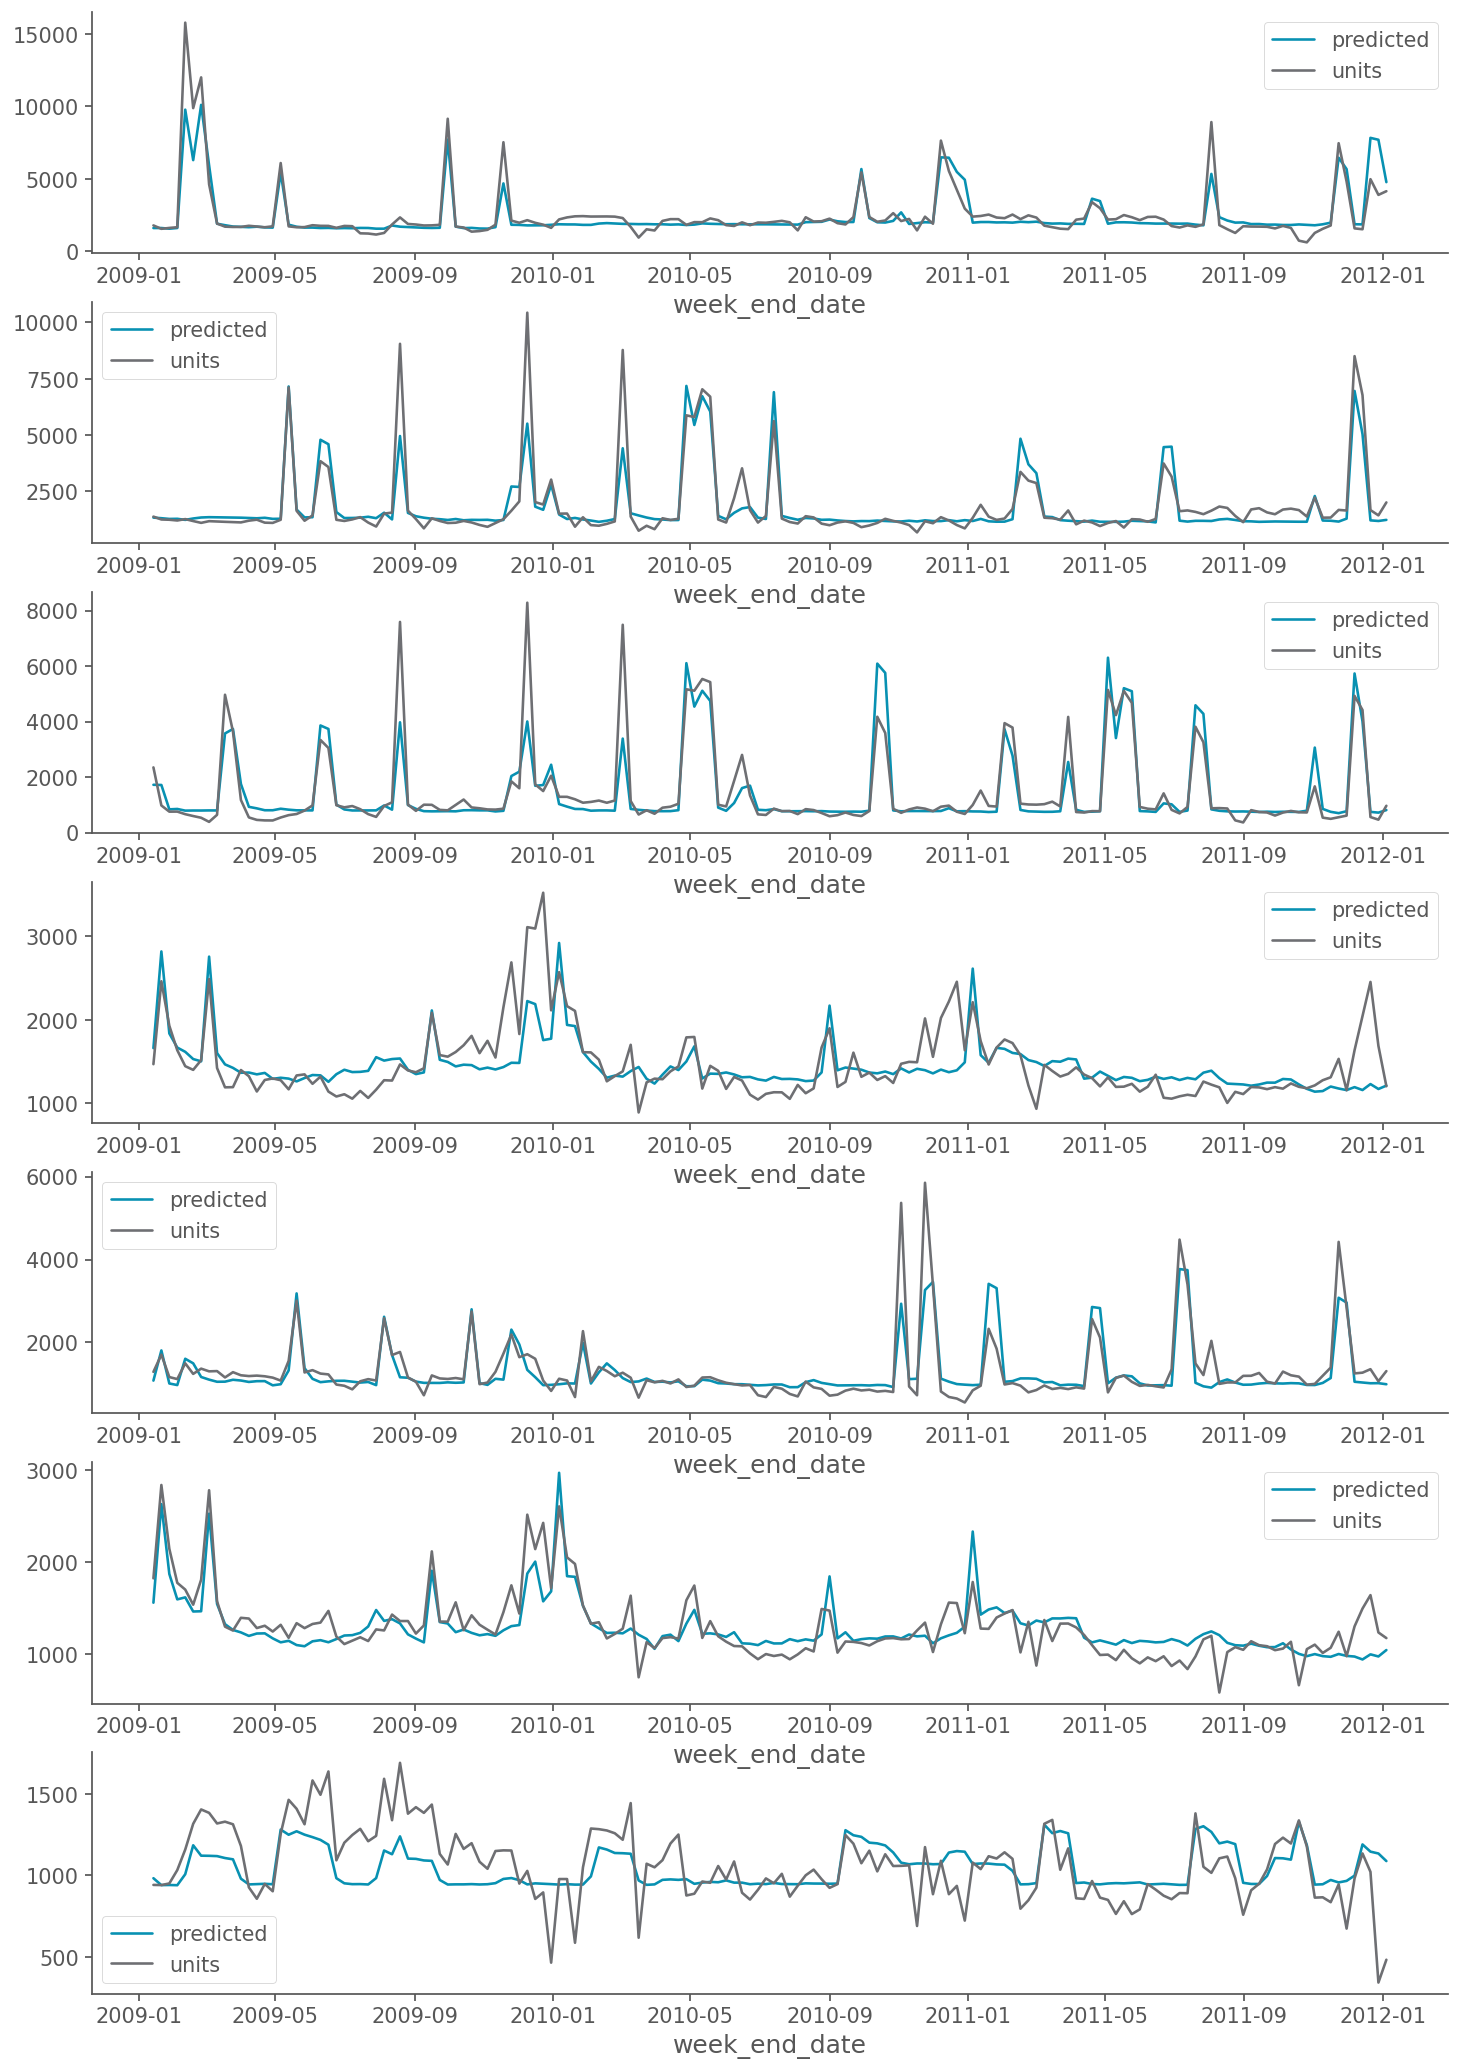

In [12]:
import matplotlib.pyplot as plt

# Review top N UPCs in Store Cluster Y
n = 7
store_cluster = 1
top_n = (
    df
    .where(f"store_cluster={store_cluster}")
    .groupby('upc')
    .agg(
        F.sum('units').alias('units'),
        F.sum('yhat_units').alias('yhat_units'),
    )
    .orderBy(F.desc('units'))
    .limit(n)
    .select('upc')
    .toPandas().values
)

# Set custom styling
plt.style.use('custom.mplstyle')
fig,ax = plt.subplots(nrows=n, figsize=(14,3*n))

for i, [upc] in enumerate(top_n):    
    (
        df
        .where(f"store_cluster={store_cluster} and upc={upc}")
        .groupby('week_end_date')
        .agg(
            F.sum('units').alias('units'),
            F.sum('yhat_units').alias('predicted')
        )
        .orderBy('week_end_date')
        .toPandas()
        .plot(x='week_end_date', y=['predicted','units'], ax=ax[i])
    )
    print(f"UPC: {upc}")